In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns
import csv

### Tournmanet Dataframe

In [2]:
# Import tournaments data and create dataframe, adding column headings.
tournaments = pd.read_csv('data/tournaments_1877-2017_UNINDEXED.csv', header=None)
tournamentscolumns = ['tourney_year','tourney_order','tourney_name','tourney_id','tourney_slug','tourney_location',
                      'tourney_dates','tourney_month','tourney_day','tourney_singles_draw','tourney_doubles_draw',
                      'tourney_conditions','tourney_surface','tourney_fin_commit','tourney_url_suffix','singles_winner_name',
                      'singles_winner_url','singles_winner_player_slug','singles_winner_player_id','doubles_winner_1_name',
                      'doubles_winner_1_url','doubles_winner_1_player_slug','doubles_winner_1_player_id','doubles_winner_2_name',
                      'doubles_winner_2_url','doubles_winner_2_player_slug','doubles_winner_2_player_id','tourney_year_id']
tournaments.columns = tournamentscolumns

In [3]:
# Drop unnecessary columns in tournaments. (Only keep 'tourney_dates' and 'tourney_year_id'). Will allow match dates to be included in model.
tournaments.drop(["tourney_year","tourney_order","tourney_name","tourney_id","tourney_slug","tourney_location",
                  "tourney_month","tourney_day","tourney_singles_draw","tourney_doubles_draw","tourney_conditions","tourney_surface",
                  "tourney_fin_commit","tourney_url_suffix","singles_winner_name","singles_winner_url","singles_winner_player_slug",
                  "singles_winner_player_id","doubles_winner_1_name","doubles_winner_1_url","doubles_winner_1_player_slug",
                  "doubles_winner_1_player_id","doubles_winner_2_name","doubles_winner_2_url","doubles_winner_2_player_slug",
                  "doubles_winner_2_player_id"], inplace=True, axis=1)

In [4]:
# Convert tournament date strings to datetime objects.
tournaments['tourney_dates'] = pd.to_datetime(pd.Series(tournaments['tourney_dates']))

In [5]:
tournaments = tournaments[(tournaments['tourney_dates'].dt.year > 1989) ]

In [6]:
# Create 'date' column for later merging.
# tournaments['date'] = tournaments['tourney_dates']

### Score Dataframe

In [7]:
# Import scores data and create dataframe, adding column headings.
scores = pd.read_csv('data/match_scores_1991-2016_unindexed.csv', header=None)
scorescolumns = ['tourney_year_id','tourney_order','tourney_slug','tourney_url_suffix','tourney_round_name','round_order',
                 'match_order','winner_name','winner_player_id','winner_slug','loser_name','loser_player_id','loser_slug',
                 'winner_seed','loser_seed','match_score_tiebreaks','winner_sets_won','loser_sets_won','winner_games_won',
                 'loser_games_won','winner_tiebreaks_won','loser_tiebreaks_won','match_id','match_stats_url_suffix']
scores.columns = scorescolumns

In [8]:
# Drop unnecessary columns in scores.
scores.drop(["tourney_order","tourney_slug","tourney_url_suffix","tourney_round_name","round_order","match_order","winner_name",
             "winner_slug","loser_name","loser_slug","winner_seed","loser_seed","match_stats_url_suffix"], inplace=True, axis=1)

In [9]:
# Drop empty rows in scores.
nan_rows_scores = scores[ (scores['match_score_tiebreaks'].isnull() == True) ].index
scores.drop(nan_rows_scores, inplace=True)

### Winner and Loser Dataframes

In [10]:
winner = pd.DataFrame([scores.tourney_year_id, scores.winner_player_id, scores.match_score_tiebreaks,
                       scores.winner_sets_won, scores.winner_games_won, scores.winner_tiebreaks_won, scores.match_id]).transpose()

In [11]:
loser = pd.DataFrame([scores.tourney_year_id, scores.loser_player_id, scores.match_score_tiebreaks,
                       scores.loser_sets_won, scores.loser_games_won, scores.loser_tiebreaks_won, scores.match_id]).transpose()

In [12]:
winner = winner.rename(columns={'winner_player_id': 'player_id'})
loser = loser.rename(columns={'loser_player_id': 'player_id'})

In [13]:
winner = pd.merge(left=winner,right=tournaments,how='left',left_on='tourney_year_id',right_on='tourney_year_id')

In [14]:
loser = pd.merge(left=loser,right=tournaments,how='left',left_on='tourney_year_id',right_on='tourney_year_id')

### Rankings Dataframe

In [15]:
rankings = pd.read_csv('data/rankings_1973-2017_csv.csv', header=0, low_memory=False)

In [16]:
# Drop rows before 1990.
drop_rank_rows = rankings[ (rankings['week_year'] < 1990)].index
rankings = rankings.drop(drop_rank_rows)

In [17]:
# Drop unnecessary columns in rankings.
rankings.drop(["move_positions","move_direction","player_age","tourneys_played","player_url","player_slug"], inplace=True, axis=1)

In [18]:
# Convert rankings date strings to datetime objects.
rankings['week_title'] = pd.to_datetime(pd.Series(rankings['week_title']))

In [19]:
# Create 'date' column for later merging.
rankings['date'] = rankings['week_title']

In [20]:
# sort rankings by year, week, day and rank.
rankings = rankings.sort_values(['week_title'])

### Create rounding dataframe for dates.

In [21]:
# Create dataframe of all dates from Jan 1, 1991 to Dec 31, 2017.
df=pd.DataFrame({'date':pd.date_range('1990-12-15','2017-12-31')})

In [22]:
# Create reference column for the beginning day of the week for each day.
df['BeginWeek']=np.where(df.date.dt.weekday==0, # offset on Non Mondays only
                        df['date'],
                        df['date']-pd.DateOffset(weekday=0,weeks=1),
                        )

C:\Users\Owner\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


### Add rounding dates to model dataframes for merging.

In [23]:
rankings = pd.merge(left=rankings,right=df,how='left',left_on='date',right_on='date')

In [24]:
winner = pd.merge(left=winner,right=df,how='left',left_on='tourney_dates', right_on='date')

In [25]:
loser = pd.merge(left=loser,right=df,how='left',left_on='tourney_dates', right_on='date')

### Clean rankings/winner/loser of redundant date columns.

In [27]:
# Drop unnecessary columns in rankings/winner/loser.
rankings.drop(["week_title","date"], inplace=True, axis=1)
winner.drop(["tourney_dates","date"], inplace=True, axis=1)
loser.drop(["tourney_dates","date"], inplace=True, axis=1)

### Merge rankings into winner and loser dataframes.

In [31]:
winner1 = pd.merge(winner,rankings,on=["player_id","BeginWeek"], how="left")

In [32]:
loser1 = pd.merge(loser,rankings,on=["player_id","BeginWeek"], how="left")

### Clean data in Winner1 and Loser 1 prior to master merge with matchstats.

In [35]:
# Drop empty rows in winner1/loser1.
nan_rows_winner1 = winner1[ (winner1['week_year'].isnull() == True) ].index
winner1.drop(nan_rows_winner1, inplace=True)

nan_rows_loser1 = loser1[ (loser1['week_year'].isnull() == True) ].index
loser1.drop(nan_rows_loser1, inplace=True)

### Data Checking Code

In [39]:
# winner1.query('player_id=="v306" & week_year=="2014" ')
# winner1.loc[winner1['week_year'].isnull() == True]

### Match Statistics Dataframe

In [40]:
matchstats = pd.read_csv('data/match_stats_1991-2016_unindexed.csv', header=None)
matchstatscolumns = ['tourney_order','match_id','match_stats_url_suffix','match_time','match_duration','winner_aces',
                     'winner_double_faults','winner_first_serves_in','winner_first_serves_total','winner_first_serve_points_won',
                     'winner_first_serve_points_total','winner_second_serve_points_won','winner_second_serve_points_total',
                     'winner_break_points_saved','winner_break_points_serve_total','winner_service_points_won',
                     'winner_service_points_total','winner_first_serve_return_won','winner_first_serve_return_total',
                     'winner_second_serve_return_won','winner_second_serve_return_total','winner_break_points_converted',
                     'winner_break_points_return_total','winner_service_games_played','winner_return_games_played',
                     'winner_return_points_won','winner_return_points_total','winner_total_points_won','winner_total_points_total',
                     'loser_aces','loser_double_faults','loser_first_serves_in','loser_first_serves_total',
                     'loser_first_serve_points_won','loser_first_serve_points_total','loser_second_serve_points_won',
                     'loser_second_serve_points_total','loser_break_points_saved','loser_break_points_serve_total',
                     'loser_service_points_won','loser_service_points_total','loser_first_serve_return_won',
                     'loser_first_serve_return_total','loser_second_serve_return_won','loser_second_serve_return_total',
                     'loser_break_points_converted','loser_break_points_return_total','loser_service_games_played',
                     'loser_return_games_played','loser_return_points_won','loser_return_points_total','loser_total_points_won',
                     'loser_total_points_total']
matchstats.columns = matchstatscolumns
# matchstats.head()

In [41]:
# Drop empty rows in matchstats.
nan_rows_match_time = matchstats[ (matchstats['match_time'].isnull() == True) ].index
matchstats.drop(nan_rows_match_time, inplace=True)

### Create separate dataframes for winners and losers match stats.

In [ ]:
'''
# Create winner stats dataframe as a copy of matchstats.
winnerstats = matchstats.copy()

# Drop loser stats from winner stats dataframe.
# Drop unnecessary columns in rankings.
winnerstats.drop(["loser_aces","loser_double_faults","loser_first_serves_in","loser_first_serves_total",
                  "loser_first_serve_points_won","loser_first_serve_points_total","loser_second_serve_points_won",
                  "loser_second_serve_points_total","loser_break_points_saved","loser_break_points_serve_total",
                  "loser_service_points_won","loser_service_points_total","loser_first_serve_return_won",
                  "loser_first_serve_return_total","loser_second_serve_return_won","loser_second_serve_return_total",
                  "loser_break_points_converted","loser_break_points_return_total","loser_service_games_played",
                  "loser_return_games_played","loser_return_points_won","loser_return_points_total","loser_total_points_won",
                  "loser_total_points_total"], inplace=True, axis=1)
                  
'''

In [ ]:
'''
# Create loser stats dataframe as a copy of matchstats.
loserstats = matchstats.copy()

# Drop nwiner stats from winner stats dataframe.
# Drop unnecessary columns in rankings.
loserstats.drop(["winner_aces","winner_double_faults","winner_first_serves_in","winner_first_serves_total",
                  "winner_first_serve_points_won","winner_first_serve_points_total","winner_second_serve_points_won",
                  "winner_second_serve_points_total","winner_break_points_saved","winner_break_points_serve_total",
                  "winner_service_points_won","winner_service_points_total","winner_first_serve_return_won",
                  "winner_first_serve_return_total","winner_second_serve_return_won","winner_second_serve_return_total",
                  "winner_break_points_converted","winner_break_points_return_total","winner_service_games_played",
                  "winner_return_games_played","winner_return_points_won","winner_return_points_total","winner_total_points_won",
                  "winner_total_points_total"], inplace=True, axis=1)
                  '''

### Rename player id to winner/loser id.

In [42]:
winner1 = winner1.rename(columns={'player_id': 'winner_player_id'})
loser1 = loser1.rename(columns={'player_id': 'loser_player_id'})

In [43]:
winner1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94858 entries, 0 to 95356
Data columns (total 14 columns):
tourney_year_id          94858 non-null object
winner_player_id         94858 non-null object
match_score_tiebreaks    94858 non-null object
winner_sets_won          94858 non-null object
winner_games_won         94858 non-null object
winner_tiebreaks_won     94858 non-null object
match_id                 94858 non-null object
BeginWeek                94858 non-null datetime64[ns]
week_year                94858 non-null float64
week_month               94858 non-null float64
week_day                 94858 non-null float64
rank_text                94858 non-null object
rank_number              94858 non-null float64
ranking_points           94858 non-null float64
dtypes: datetime64[ns](1), float64(5), object(8)
memory usage: 10.9+ MB


In [44]:
loser1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93769 entries, 0 to 95356
Data columns (total 14 columns):
tourney_year_id          93769 non-null object
loser_player_id          93769 non-null object
match_score_tiebreaks    93769 non-null object
loser_sets_won           93769 non-null object
loser_games_won          93769 non-null object
loser_tiebreaks_won      93769 non-null object
match_id                 93769 non-null object
BeginWeek                93769 non-null datetime64[ns]
week_year                93769 non-null float64
week_month               93769 non-null float64
week_day                 93769 non-null float64
rank_text                93769 non-null object
rank_number              93769 non-null float64
ranking_points           93769 non-null float64
dtypes: datetime64[ns](1), float64(5), object(8)
memory usage: 10.7+ MB


### Bring in rankings data for winners1 and losers1 dataframes into the matchstats dataframe.

In [45]:
# Merge matchstats and winner1 dataframe first.
matchstats1 = pd.merge(matchstats,winner1,on=["match_id"], how="left")

In [46]:
matchstats1.head(2)

,tourney_order,match_id,match_stats_url_suffix,match_time,match_duration,winner_aces,winner_double_faults,winner_first_serves_in,winner_first_serves_total,winner_first_serve_points_won,...,winner_sets_won,winner_games_won,winner_tiebreaks_won,BeginWeek,week_year,week_month,week_day,rank_text,rank_number,ranking_points
0,0,1991-7308-k181-l206,/en/scores/1991/7308/MS002/match-stats,01:20:00,80.0,3.0,0.0,0.0,65.0,29.0,...,2,13,0,1990-12-31,1990.0,12.0,31.0,51,51.0,0.0
1,0,1991-7308-k181-s351,/en/scores/1991/7308/MS001/match-stats,01:29:00,89.0,1.0,2.0,44.0,65.0,31.0,...,2,13,0,1990-12-31,1990.0,12.0,31.0,51,51.0,0.0


In [48]:
matchstats1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91825 entries, 0 to 91824
Data columns (total 66 columns):
tourney_order                       91825 non-null int64
match_id                            91825 non-null object
match_stats_url_suffix              91825 non-null object
match_time                          91825 non-null object
match_duration                      91825 non-null float64
winner_aces                         91825 non-null float64
winner_double_faults                91825 non-null float64
winner_first_serves_in              91825 non-null float64
winner_first_serves_total           91825 non-null float64
winner_first_serve_points_won       91825 non-null float64
winner_first_serve_points_total     91825 non-null float64
winner_second_serve_points_won      91825 non-null float64
winner_second_serve_points_total    91825 non-null float64
winner_break_points_saved           91825 non-null float64
winner_break_points_serve_total     91825 non-null float64
winner_serv

### Data Checking Code

In [65]:
# matchstats1.query('winner_player_id=="v306" & match_duration < 91 ')
# matchstats1.loc[matchstats1['winner_player_id'].isnull() == True]

In [66]:
matchstats1 = pd.merge(matchstats1,loser1,on=["match_id"], how="left")

In [67]:
matchstats1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91863 entries, 0 to 91862
Data columns (total 79 columns):
tourney_order                       91863 non-null int64
match_id                            91863 non-null object
match_stats_url_suffix              91863 non-null object
match_time                          91863 non-null object
match_duration                      91863 non-null float64
winner_aces                         91863 non-null float64
winner_double_faults                91863 non-null float64
winner_first_serves_in              91863 non-null float64
winner_first_serves_total           91863 non-null float64
winner_first_serve_points_won       91863 non-null float64
winner_first_serve_points_total     91863 non-null float64
winner_second_serve_points_won      91863 non-null float64
winner_second_serve_points_total    91863 non-null float64
winner_break_points_saved           91863 non-null float64
winner_break_points_serve_total     91863 non-null float64
winner_serv

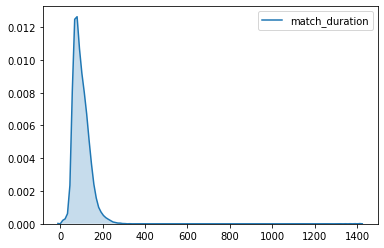

In [68]:
import seaborn as sns
x = matchstats1.match_duration
sns.kdeplot(x, shade=True)